# Demo: Explaining Diabetic Data

In [1]:
import os
os.chdir("../")

In [11]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import torch
import matplotlib.pylab as plt

from sklearn.datasets import load_diabetes
from gpytorch.kernels import RBFKernel

from src.gp_models.VariationalGPRegression import VariationalGPRegression
from src.explanation_algorithms.BayesGPSHAP import BayesGPSHAP
from src.utils.visualisation.deterministic_values import summary_plot
from src.utils.visualisation.stochastic_values import local_explanation_plot, global_explanation_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Prepare data

In [3]:
diabetes = load_diabetes()
X, y, feature_names = diabetes.data, diabetes.target, diabetes.feature_names
X, y = torch.tensor(X).float(), torch.tensor(y).float()

# Standardise
scale = y.std().numpy()
y = (y - y.mean()) / y.std()

### Fit a Variational GP model

In [4]:
kernel = RBFKernel
gp_regression = VariationalGPRegression(
    X, y, kernel=kernel, num_inducing_points=150, batch_size=128
)
gp_regression.fit(learning_rate=1e-2, training_iteration=300)

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

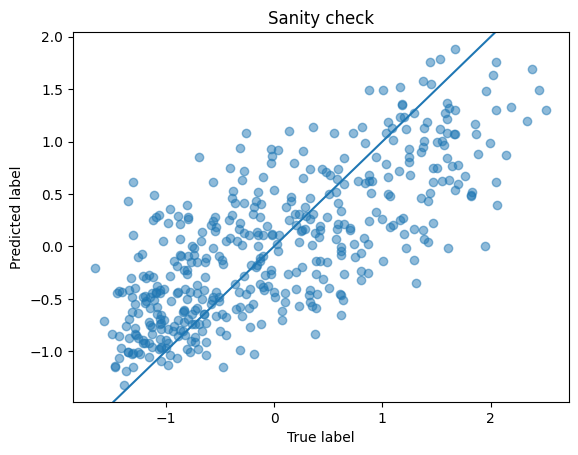

In [5]:
ypred = gp_regression.predict_include_likelihood(X).mean.detach()
plt.scatter(y, ypred, alpha=.5)
plt.axline((0, 0), slope=1)
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Sanity check")
plt.show()

The regression is capturing signals. Now proceed to explain this function.

### Fit a BayesGPSHAP explanier model.

In [6]:
bayes_gpshap = BayesGPSHAP(train_X=X,
                           scale=scale,
                           model=gp_regression,
                           kernel=kernel(),
                           include_likelihood_noise_for_explanation=False)
bayes_gpshap.fit_bayesgpshap(X, num_coalitions=2**X.shape[1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1023/1023 [00:04<00:00, 254.98it/s]


### Visualisation

We can look at the mean stochastic Shapley values.

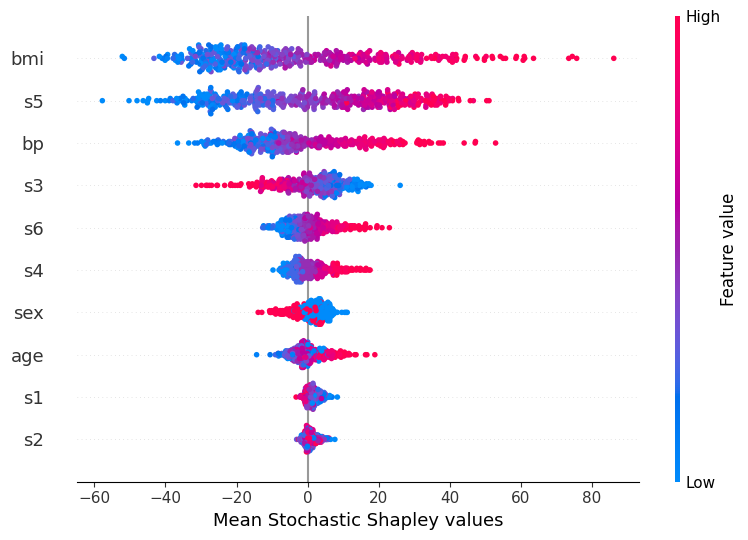

In [7]:
mean_stochastic_shapley_values = bayes_gpshap.return_deterministic_shapley_values()
summary_plot(mean_stochastic_shapley_values, X, feature_names=feature_names)
plt.xlabel("Mean Stochastic Shapley values")
plt.show()

and study the uncertainties around local explanations.

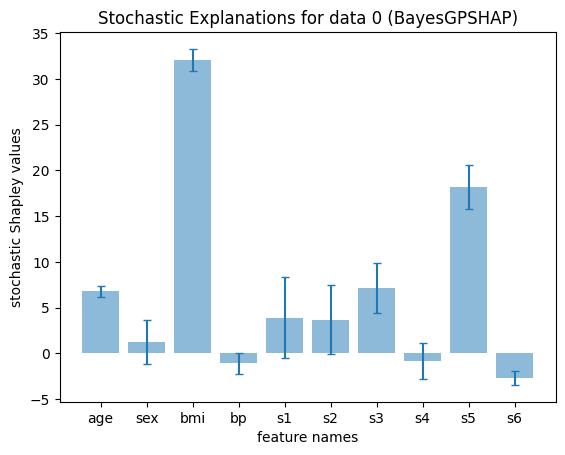

In [8]:
local_explanation_plot(data_id=0,
                       feature_names=feature_names,
                       explanation_algorithm=bayes_gpshap,
                       uncertainty_source="BayesGPSHAP",
                       coverage=1
                      )

We can also summarise the local stochastic explanations and have a general summary for global feature attributions.

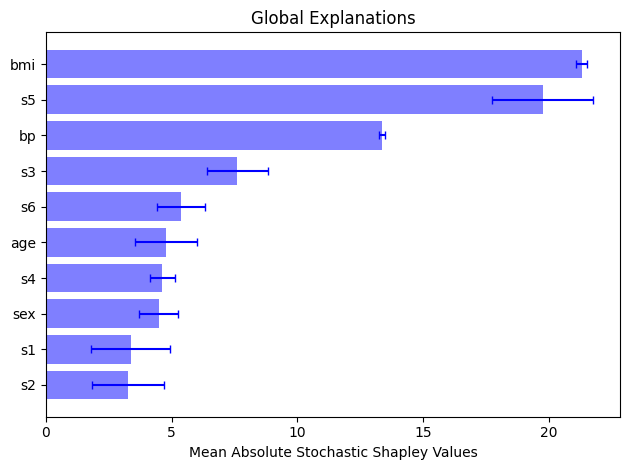

In [12]:
global_explanation_plot(feature_names=feature_names,
                        explanation_algorithm=bayes_gpshap,
                        uncertainty_source="BayesGPSHAP",
                        coverage=1
                       )